# Phoneme Data Analysis

This notebook will analyze and clean the **phoneme dataset** which can be found at this [blog](https://machinelearningmastery.com/predictive-model-for-the-phoneme-imbalanced-classification-dataset/), for the usage in the models' comparison section of my masters' project.

Data description:

    The aim of this dataset is to distinguish between nasal (class 0) and oral sounds (class 1). Five different attributes were chosen to characterize each vowel: they are the amplitudes of the five first harmonics AHi, normalised by the total energy Ene (integrated on all the frequencies): AHi/Ene. The phonemes are transcribed as follows: sh as in she, dcl as in dark, iy as the vowel in she, aa as the vowel in dark, and ao as the first vowel in water.
    
Let's analyze the data.

## Dependencies

In [3]:
# Define the root path
import os
import sys
path = os.getcwd().split('tests')[0]
# Import the necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import NearMiss
sns.set_style('darkgrid')
print(sns.__version__)

0.11.1


In [4]:
df = pd.read_csv(path+'data/raw/phoneme.csv', names=['H1','H2','H3','H4','H5','target'])
df.head()

,H1,H2,H3,H4,H5,target
0,1.240,0.875,-0.205,-0.078,0.067,0
1,0.268,1.352,1.035,-0.332,0.217,0
2,1.567,0.867,1.300,1.041,0.559,0
3,0.279,0.990,2.555,-0.738,0.000,0
4,0.307,1.272,2.656,-0.946,-0.467,0


## How many samples and attribues?

In [5]:
print("Samples: {}".format(df.shape[0]))
print("Attributes: {}".format(df.shape[1]))

Samples: 5404
Attributes: 6


## Attributes Information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 6 columns):
H1        5404 non-null float64
H2        5404 non-null float64
H3        5404 non-null float64
H4        5404 non-null float64
H5        5404 non-null float64
target    5404 non-null int64
dtypes: float64(5), int64(1)
memory usage: 253.4 KB


All attributes are **floats** and there are no missing values.

## Attributes Description

In [7]:
df.describe()

,H1,H2,H3,H4,H5,target
count,5404.000000,5404.000000,5404.000000,5404.000000,5404.000000,5404.000000
mean,0.818957,1.258802,0.764732,0.398743,0.078619,0.293486
std,0.858733,0.851057,0.925436,0.796531,0.575624,0.455401
min,-1.700000,-1.327000,-1.823000,-1.581000,-1.284000,0.000000
25%,0.243750,0.596000,-0.115000,-0.205000,-0.232250,0.000000
50%,0.492500,1.075500,0.729000,0.285500,-0.044000,0.000000
75%,1.089250,1.866250,1.484000,0.937000,0.196250,1.000000
max,4.107000,4.378000,3.199000,2.826000,2.719000,1.000000


In [8]:
df_mean = pd.DataFrame(df.mean(),columns=['mean'])
df_mean

,mean
H1,0.818957
H2,1.258802
H3,0.764732
H4,0.398743
H5,0.078619
target,0.293486


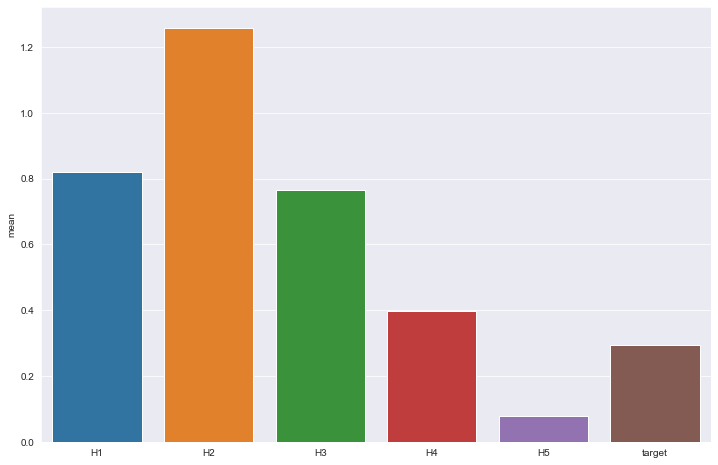

In [9]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_mean,x=df_mean.index,y='mean')
sns.set_theme(font_scale=2)

No need to scale the data!

## There are duplicates?

In [10]:
df.duplicated().value_counts()

False    5349
True       55
dtype: int64

In [11]:
print("Percentage: {}".format(df.duplicated().value_counts()[1]*100/df.shape[0]))

Percentage: 1.0177646188008882


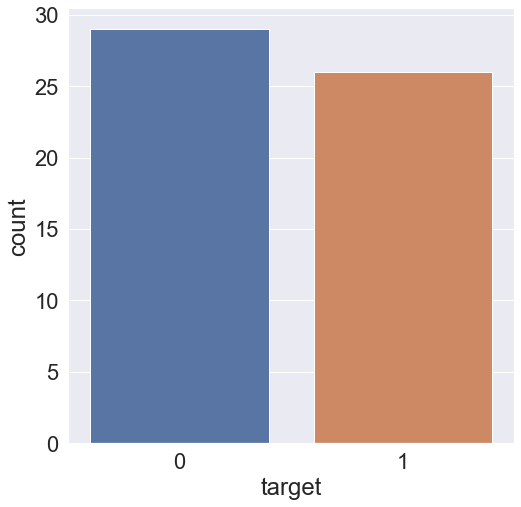

In [12]:

dup = df.loc[df.duplicated()==True]
plt.figure(figsize=(8,8))
sns.countplot(x='target',data=dup)

There are so few data duplicated, and it's almost equally distributed between the classes

In [13]:
df_1 = df.drop_duplicates(keep='first')

In [14]:
df_1.reset_index(drop=True, inplace=True)
df_1.shape

(5349, 6)

## Proportion of the classes!

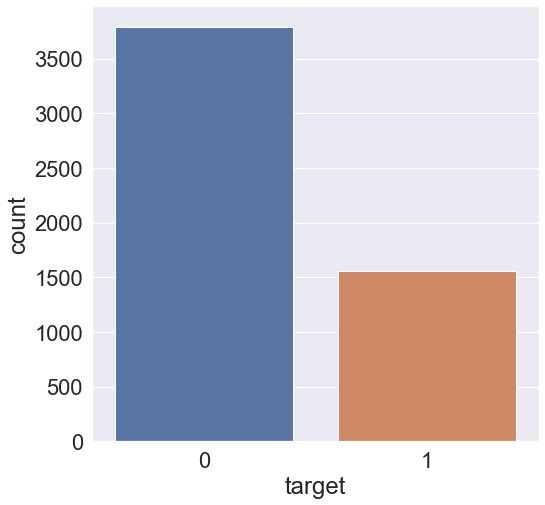

In [15]:
plt.figure(figsize=(8,8))
sns.countplot(x='target',data=df_1)

In [16]:
print("Class 0: {}".format(df_1.loc[df_1['target']==0].shape[0]*100/df_1.shape[0]))
print("Class 1: {}".format(df_1.loc[df_1['target']==1].shape[0]*100/df_1.shape[0]))

Class 0: 70.83567021873247
Class 1: 29.164329781267526


The dfference is that **70%** is of class 0, and **30%** of class 1. So we will must balance this, but before balancing, we will make a scatter plot.

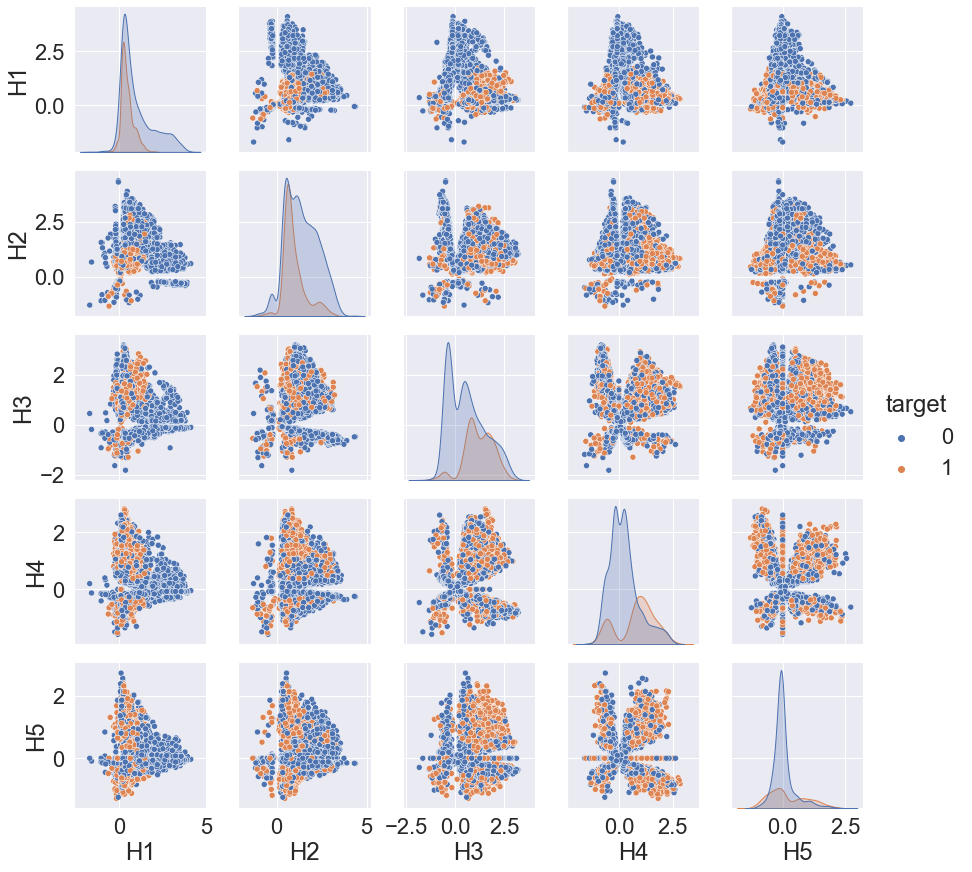

In [17]:
sns.pairplot(data=df_1,hue='target')

In [24]:
import scipy as sp

cols = df_1.columns.values[:-1]
diff = df_1[cols] - df_1[cols].mean()
cov = df_1[cols].cov().values
try:
    chole = np.linalg.cholesky(cov)
except:
    print("Failed")
inv = sp.linalg.inv(cov)
left = diff.values@inv
mahal = left@diff.values.T
mahal = pd.DataFrame(mahal.diagonal(),columns=['mahalanobis'])
mahal.head()

,mahalanobis
0,2.229622
1,1.592314
2,3.588837
3,6.122153
4,8.373709


In [26]:
deg = df_1.shape[1]-1
value = sp.stats.chi2.ppf((1-0.05), df=deg)
value

11.070497693516351

In [29]:
mahal[mahal['mahalanobis']>value].head()

,mahalanobis
33,11.410677
40,11.583127
64,16.596316
80,15.027126
117,12.898108


In [30]:
indexes = mahal[mahal['mahalanobis']>value].index
indexes

Int64Index([  33,   40,   64,   80,  117,  124,  153,  230,  294,  297,
            ...
            5158, 5163, 5207, 5220, 5260, 5265, 5280, 5284, 5308, 5334],
           dtype='int64', length=256)

In [32]:
df_outlier = df_1.loc[indexes,df_1.columns.values]
df_outlier.head()

,H1,H2,H3,H4,H5,target
33,0.747,1.029,1.346,-0.998,1.722,1
40,3.386,-0.301,0.136,-0.078,-0.055,0
64,-0.073,-0.250,-0.445,1.539,-1.184,1
80,0.081,0.309,0.445,-0.697,1.824,0
117,0.350,0.585,0.907,2.188,1.632,1


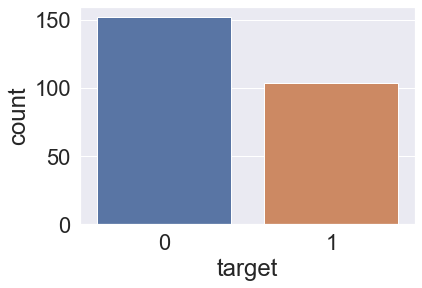

In [34]:
sns.countplot(data=df_outlier,x='target')

In [37]:
df_outlier['target'].value_counts()*100/df_outlier.shape[0]

0    59.375
1    40.625
Name: target, dtype: float64

In [38]:
df_new = df_1.drop(index=indexes)
df_new.reset_index(drop=True, inplace=True)
df_new

,H1,H2,H3,H4,H5,target
0,1.240,0.875,-0.205,-0.078,0.067,0
1,0.268,1.352,1.035,-0.332,0.217,0
2,1.567,0.867,1.300,1.041,0.559,0
3,0.279,0.990,2.555,-0.738,0.000,0
4,0.307,1.272,2.656,-0.946,-0.467,0
5,0.960,0.712,-0.143,0.091,-0.061,0
6,2.941,0.657,1.493,-0.331,-0.123,0
7,0.401,1.159,2.064,-0.690,-0.308,0
8,0.229,1.748,0.634,0.259,0.000,0
9,0.303,0.609,0.474,1.427,-0.811,1


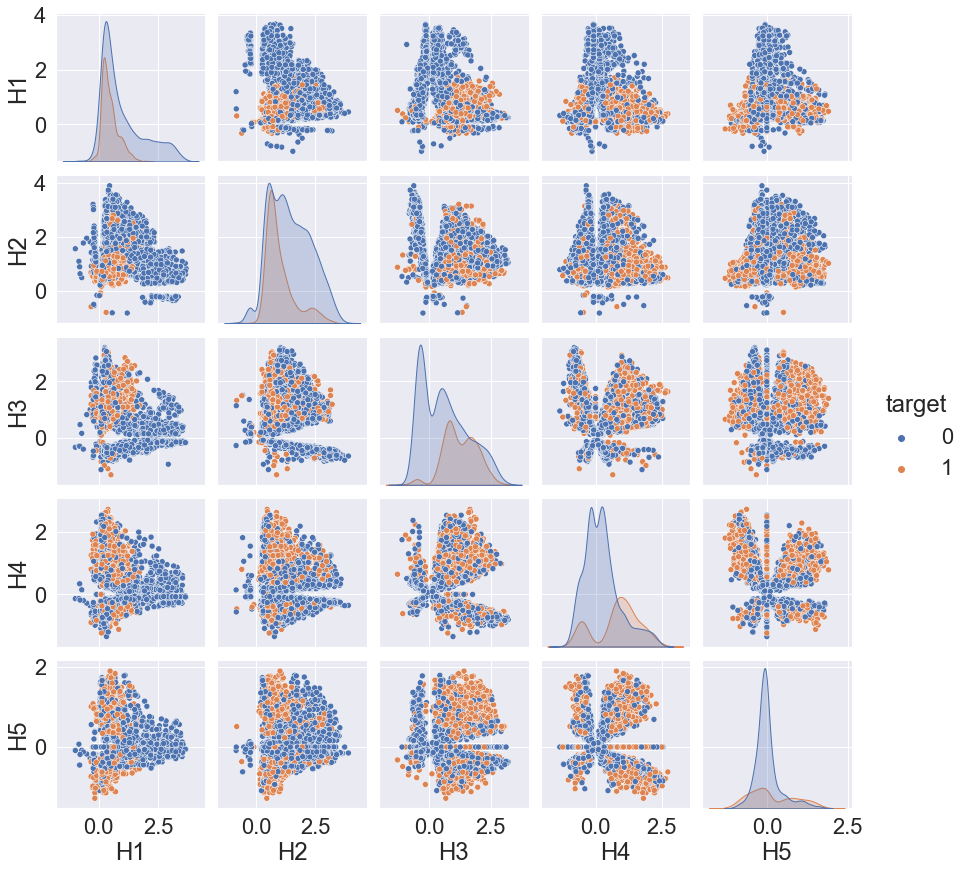

In [40]:
sns.pairplot(data=df_new,hue='target')

In [41]:
skew = df_new.skew()
skew[skew>1].sort_values(ascending=False)

H1    1.457650
H5    1.032955
dtype: float64

In [43]:
skew[skew<-1].sort_values()

Series([], dtype: float64)

In [44]:
kurt = df_new.kurtosis()
kurt

H1        1.348762
H2       -0.515830
H3       -0.898861
H4       -0.446540
H5        1.129668
target   -1.101634
dtype: float64

Let's resample!

In [68]:
df_y = df_new['target']
df_x = df_new[df_new.columns.values[:-1]]

In [69]:
x_resample, y_resample = NearMiss(version=2).fit_sample(df_x, df_y)


In [70]:
x_resample.shape

(2912, 5)

In [71]:
y_resample.shape

(2912,)

In [72]:
df_sample = pd.concat([x_resample,y_resample],axis=1)

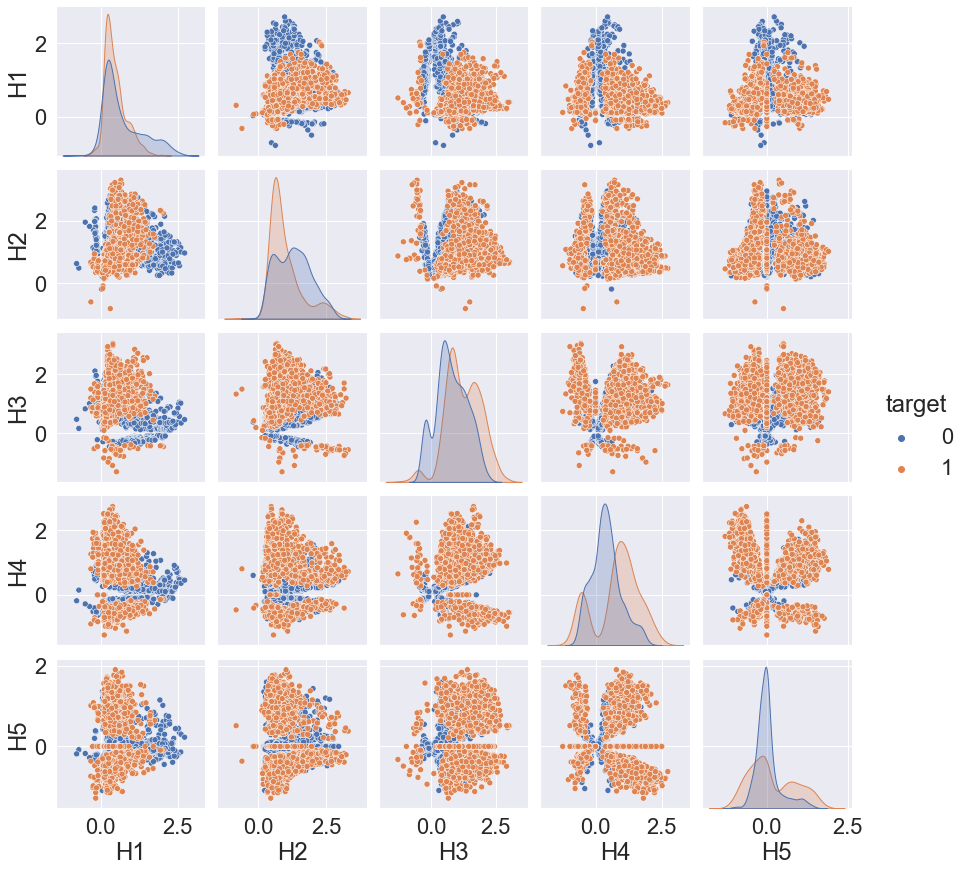

In [73]:
sns.pairplot(data=df_sample,hue='target')

In [74]:
skew = df_sample.skew()
skew[skew>1].sort_values(ascending=False)

H1    1.393594
dtype: float64

In [75]:
skew[skew<-1].sort_values()

Series([], dtype: float64)

In [76]:
kurt = df_sample.kurtosis()
kurt

H1        1.560704
H2       -0.124316
H3       -0.309370
H4       -0.575263
H5        0.195807
target   -2.001375
dtype: float64

In [78]:
df_sample['target']+=1

In [79]:
df_sample

,H1,H2,H3,H4,H5,target
0,0.267,1.344,0.978,0.492,-0.160,1
1,0.334,1.312,0.990,0.464,-0.201,1
2,0.419,1.303,0.851,0.463,-0.148,1
3,0.404,1.284,0.837,0.448,-0.135,1
4,0.392,1.443,1.052,0.423,0.000,1
5,0.412,1.283,0.820,0.425,-0.137,1
6,0.211,1.580,1.101,0.498,0.000,1
7,0.333,1.292,1.023,0.455,-0.199,1
8,0.351,1.331,1.073,0.488,-0.213,1
9,0.216,1.593,1.120,0.516,0.000,1


Let's save the dataset!

In [80]:
df_sample.to_csv(path+'data/cleaned/phoneme.csv', index=False)

In [81]:
sns.pairplot(data=df,hue='target',kde=True)

TypeError: pairplot() got an unexpected keyword argument 'kde'